# Part 1: create table and find top 3

In [75]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
from pyspark.sql.functions import col, sum, trim, round, monotonically_increasing_id, abs, mean, min, max
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
spark = SparkSession.builder.appName('Spark_lab3').getOrCreate()
spark

In [76]:
# make dataframe from txt file
df = spark.read.csv('StructuredData.txt', header=True)
df.show(10)
# ignore rows with missing data
required_cols = ['marsrutas', 'sustojimo data', 'svoris', 'siuntu skaicius', 'kaina procentas', 'kaina vienetais']
for c in required_cols:
    df = df.filter((col(c).isNotNull()) & (trim(col(c)) != ""))

+---------+--------------+-----------+-----+--------------+-------------+---------------+------------------------+--------+-----------------+---------------+------+------------+---------------+-----------+-----------------+-----+--------------------+-------------------+---------------+----------------------+------+--------------------------+-------------------------+------------------+-----------------+
|marsrutas|sustojimo data|sandelio id|Firma|Marsruto tipas|Masinos tipas|sustojimo tipas|sustojimo savaites diena|  laikas|Sustojimo numeris|siuntu skaicius|svoris|svorio grupe|geografine zona|pasto kodas|Aptarnavimo grupe|tipas|Laikas iki sustojimo|Laikas po sustojimo|Uzkrovimo tipas|Ar reikalingos paletes|Laukia|Sustojimo klientu skaicius|sustojimo klientu sarasas|   kaina procentas|  kaina vienetais|
+---------+--------------+-----------+-----+--------------+-------------+---------------+------------------------+--------+-----------------+---------------+------+------------+---------

In [77]:
# group dataframe by important data
agg_df = df.groupBy('marsrutas', 'sustojimo data').agg(
    sum('siuntu skaicius').alias('Bendras siuntu skaicius'),
    sum('svoris').alias('Bendras svoris'),
    (sum('kaina vienetais') / sum('kaina procentas')).alias('Pilnoji kaina')
)
# sort values 
agg_df = agg_df.orderBy('marsrutas', 'sustojimo data')
agg_df.show()

+---------+--------------+-----------------------+------------------+------------------+
|marsrutas|sustojimo data|Bendras siuntu skaicius|    Bendras svoris|     Pilnoji kaina|
+---------+--------------+-----------------------+------------------+------------------+
|      102|    2018-01-02|                   14.0|             525.3| 19.54999999999999|
|      102|    2018-01-03|                  166.0|            1411.7|29.089999999999975|
|      102|    2018-01-04|                  169.0|1554.1499999999999|             26.47|
|      102|    2018-01-05|                   15.0|            574.95| 22.55000000000001|
|      102|    2018-01-08|                   90.0|1024.8999999999999|30.490000000000016|
|      102|    2018-01-09|                  173.0|1691.3499999999997|24.359999999999985|
|      102|    2018-01-10|                  102.0| 869.6999999999999|36.510000000000055|
|      102|    2018-01-11|                  116.0|            1072.6|             34.32|
|      102|    2018-0

In [78]:
# clean output (siuntu skaicius from double to int) (pilnoji kaina and bendras svoris round to 2 after dot)
agg_df_clean = agg_df.select(
    col('marsrutas').alias('Marsrutas'),
    col('sustojimo data').alias('Diena'),
    col('Bendras siuntu skaicius').cast('int'),
    round(col('Bendras svoris'), 2).alias('Bendras svoris'),
    round(col('Pilnoji kaina'), 2).alias('Pilnoji kaina')
)
agg_df_clean.show()

+---------+----------+-----------------------+--------------+-------------+
|Marsrutas|     Diena|Bendras siuntu skaicius|Bendras svoris|Pilnoji kaina|
+---------+----------+-----------------------+--------------+-------------+
|      102|2018-01-02|                     14|         525.3|        19.55|
|      102|2018-01-03|                    166|        1411.7|        29.09|
|      102|2018-01-04|                    169|       1554.15|        26.47|
|      102|2018-01-05|                     15|        574.95|        22.55|
|      102|2018-01-08|                     90|        1024.9|        30.49|
|      102|2018-01-09|                    173|       1691.35|        24.36|
|      102|2018-01-10|                    102|         869.7|        36.51|
|      102|2018-01-11|                    116|        1072.6|        34.32|
|      102|2018-01-12|                    157|        1195.2|        30.44|
|      102|2018-01-15|                    143|        1149.3|        64.14|
|      102|2

In [80]:
# find top 3 by column
top_price = agg_df_clean.orderBy(col('Pilnoji kaina').desc()).limit(3)
top_weight = agg_df_clean.orderBy(col('Bendras svoris').desc()).limit(3)
top_parcel = agg_df_clean.orderBy(col('Bendras siuntu skaicius').desc()).limit(3)
# output top 3-s
print('top 3 kaina:')
top_price.show()
print('top 3 svoris')
top_weight.show()
print('top 3 siuntu skaicius')
top_parcel.show()

top 3 kaina:
+---------+----------+-----------------------+--------------+-------------+
|Marsrutas|     Diena|Bendras siuntu skaicius|Bendras svoris|Pilnoji kaina|
+---------+----------+-----------------------+--------------+-------------+
|       32|2018-01-31|                    148|         361.8|       286.34|
|      354|2018-01-22|                    108|       20860.2|       158.99|
|       80|2018-01-31|                    115|        8824.1|        130.7|
+---------+----------+-----------------------+--------------+-------------+

top 3 svoris
+---------+----------+-----------------------+--------------+-------------+
|Marsrutas|     Diena|Bendras siuntu skaicius|Bendras svoris|Pilnoji kaina|
+---------+----------+-----------------------+--------------+-------------+
|      292|2018-01-30|                    103|      21284.02|       107.13|
|      354|2018-01-22|                    108|       20860.2|       158.99|
|      292|2018-01-02|                    115|      19506.25|

In [81]:
# save whole dataframe (without top 3) into the excel to see whole data
import pandas as pd
main_df_pd = agg_df_clean.toPandas()
with pd.ExcelWriter('output.xlsx') as writer:
    main_df_pd.to_excel(writer, index=False)

# Part 2: build regression on table

In [82]:
# rename columns to not have spaces
df_reg = agg_df_clean.select(
    col('Bendras siuntu skaicius').alias('siuntos'),
    col('Bendras svoris').alias('svoris'),
    col('Pilnoji kaina').alias('kaina')
)
# add indexes for 3-d part (to track what value corresponds to outlier and remove outlier)
df_reg = df_reg.withColumn("row_id", monotonically_increasing_id())
df_reg.show()

+-------+-------+-----+------+
|siuntos| svoris|kaina|row_id|
+-------+-------+-----+------+
|     14|  525.3|19.55|     0|
|    166| 1411.7|29.09|     1|
|    169|1554.15|26.47|     2|
|     15| 574.95|22.55|     3|
|     90| 1024.9|30.49|     4|
|    173|1691.35|24.36|     5|
|    102|  869.7|36.51|     6|
|    116| 1072.6|34.32|     7|
|    157| 1195.2|30.44|     8|
|    143| 1149.3|64.14|     9|
|    169|1238.75|34.59|    10|
|    135| 1338.8|38.91|    11|
|    131|1103.15|37.52|    12|
|    123| 1198.2|38.41|    13|
|     31| 1096.2|41.07|    14|
|    111| 1300.7|30.44|    15|
|    123| 1526.1|37.96|    16|
|     36|  929.5|22.01|    17|
|     14|  725.2|23.45|    18|
|     18|  590.8|23.33|    19|
+-------+-------+-----+------+
only showing top 20 rows



In [83]:
# combine values (siuntos and svoris) into 1 vector
vec_assembler = VectorAssembler(inputCols=['siuntos', 'svoris'], outputCol='features')
df_vec = vec_assembler.transform(df_reg)

# drop null values just in case
df_vec = df_vec.dropna(subset=['features', 'kaina'])

# create regression model fhere input is vector from all the values compared to the kaina
lr = LinearRegression(featuresCol='features', labelCol='kaina', predictionCol='prediction')
# train model
lr_model = lr.fit(df_vec)
# transform predictions for findign outliers and ploting
pred_df = lr_model.transform(df_vec)

# get parameters
intercept = lr_model.intercept
coef = lr_model.coefficients
r2 = lr_model.summary.r2
p = lr_model.summary.pValues

# output parameters to see regression
print(f'intercept: {intercept}')
print(f'coefficients: {coef}')
print(f'R^2: {r2}')
print(f'P-values: {p}')

intercept: 25.77264371575591
coefficients: [0.05609649506822297,0.004090337406308596]
R^2: 0.25927125641735194
P-values: [0.0, 0.0, 0.0]


- Intercept -> kokia suma kai svoris ir siuntų skaičius lygūs 0
- Coef -> viena papildoma siunta padidina kainą 0.056, vienas papildomas svorio vienetas padidina kainą 0.004
- R^2 -> modelis paaiškina 25.93% kainos variacijos
- Svarbesnis yra siuntų skaičius, bet modelis blogai paaiškina duomenis, todėl jis yra 'geriausias iš blogiausių'

# Part 3: data analysis

Variantai: įkelti daugiau duomenų tipų, ignoruoti eilutes su keistais duomenimis, sunormuoti duomenis, išsirinkti geriau koreliuojančius duomenis su kainą

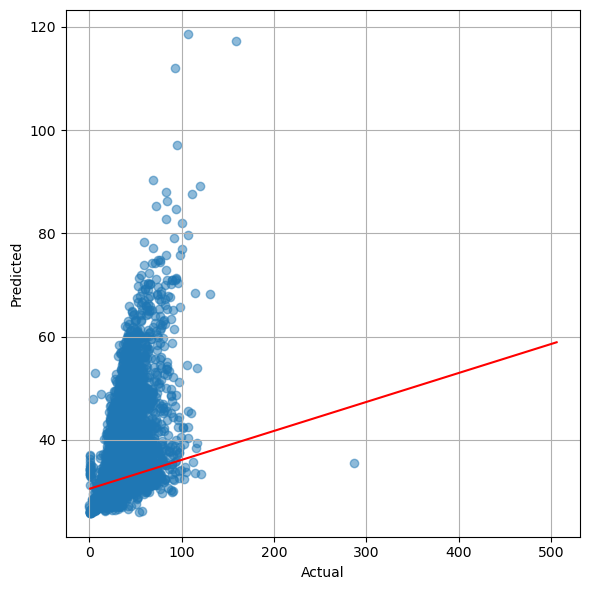

In [84]:
def plot_regression(pred, reg, intercept, coef):
    # transform data for ploting
    pred = pred.select('kaina', 'prediction').toPandas()
    # values for regression line
    svoris_mean = reg.select(mean('svoris')).collect()[0][0]
    siuntos_min = reg.select(min('siuntos')).collect()[0][0]
    siuntos_max = reg.select(max('siuntos')).collect()[0][0]
    # evenly spaced points for line
    siuntos_range = np.linspace(siuntos_min, siuntos_max, 100)
    # calculate each point in line using values
    predicted_kaina = intercept + coef[0] * siuntos_range + coef[1] * svoris_mean

    # plot data
    plt.figure(figsize=(6, 6))
    # predicted vs actual dots
    plt.scatter(pred['kaina'], pred['prediction'], alpha=0.5)
    # regression line
    plt.plot(siuntos_range, predicted_kaina, color='red')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_regression(pred_df, df_reg, intercept, coef)

In [85]:
# get residuals
pred_df = pred_df.withColumn('residual', col('kaina') - col('prediction'))
# calculate standard deviation
residual_stddev = pred_df.select(sf.stddev('residual')).collect()[0][0]
# find outliers where error > 3 of standard deviation
outliers = pred_df.filter(abs(col('residual')) > 3 * residual_stddev).select('row_id')
# filter dataframe
df_reg_clean = df_reg.join(outliers, on='row_id', how='left_anti')

intercept: 25.150530037867895
coefficients: [0.05585100243284745,0.004012627367692449]
R^2: 0.3151570458023524
P-values: [0.0, 0.0, 0.0]


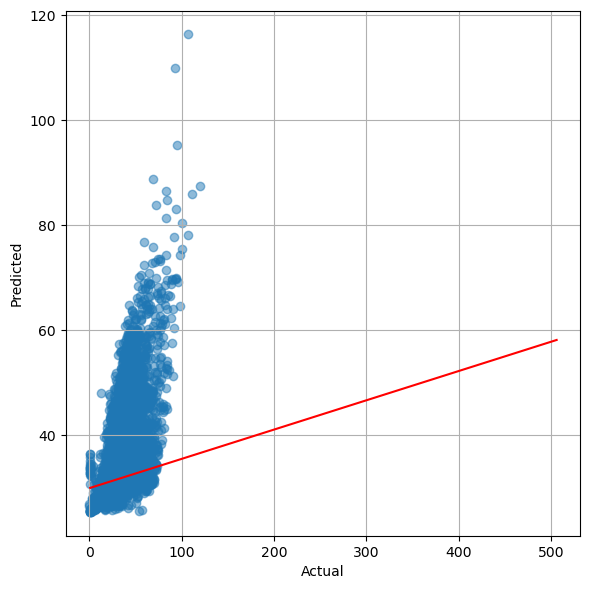

In [ ]:
# rerun regression
df_vec_clean = vec_assembler.transform(df_reg_clean)
df_vec_clean = df_vec_clean.dropna(subset=['features', 'kaina'])

# normalize values
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scaler_model = scaler.fit(df_vec_clean)
df_scaled = scaler_model.transform(df_vec_clean)
lr_scaled = LinearRegression(featuresCol='scaledFeatures', labelCol='kaina')
lr_model_clean = lr_scaled.fit(df_scaled)
df_pred_clean = lr_model_clean.transform(df_scaled)

# get parameters
intercept_clean = lr_model_clean.intercept
coef_clean = lr_model_clean.coefficients
r2_clean = lr_model_clean.summary.r2
p_clean = lr_model_clean.summary.pValues

scaler_mean = scaler_model.mean.toArray()
scaler_std = scaler_model.std.toArray()

# Convert coefficients back to original scale
coef_original = coef_clean / scaler_std
intercept_original = intercept_clean - np.sum(coef_clean * scaler_mean / scaler_std)

# # Then plot with the original function

# output parameters to see regression
print(f'intercept: {intercept_original}')
print(f'coefficients: {coef_original}')
print(f'R^2: {r2_clean}')
print(f'P-values: {p_clean}')

# # plot new results
plot_regression(df_pred_clean, df_reg_clean, intercept_original, coef_original)

In [88]:
spark.stop()